In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import gauss
from random import uniform
import matplotlib.pyplot as plt
import math
import numpy as np
from SALib.sample import saltelli 
from SALib.analyze import sobol
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import ticker

## Example Run

These are the values that we feed from the database

In [91]:
years = [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
TAM_size = [27775, 28488, 29160, 29836, 30515, 31064, 31880, 32565, 33251, 33938, 34733]
Target_Market_size_ref = [321, 330, 366, 403, 441, 490, 521,562, 604,647,716]
Total_DIRECT_GHG_footprint_of_TAM_ref = [13844, 13991, 14107, 14215, 14315, 14344,14455,14493,14521,14537,14587]
#numerator is MtCO2e; denominator varies by technology


INDIRECT_GHG_intensity_of_Target_Market_ref = 0.091558
# MtCO2e
Total_DIRECT_GHG_footprint_of_Target_Market_ref = 0.0  

Elasticity_of_demand_for_Tarket_Market = -.75#unitless

The MarketShareHandler class handles inputs for market share.

In [94]:
"""
This is user input value of market share solution and
"""
Market_Share_of_Solution = [1,1,1,1,1,1,1,1,1,1,1]

#constructor builds variables from Market Shares and Years
msos_handler = MarketShareHandler(Market_Share_of_Solution, 
                                  years)

#function takes interpolate parameters as inputs
Market_Share_of_Solution_arr = msos_handler.convert_to_series(method=None, 
                                                              include_raw=False)
Market_Share_of_Solution_arr

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

We then feed the market share values into the Report Class

min cum:  797.1397237412764 max cum: 810.5730810393495


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



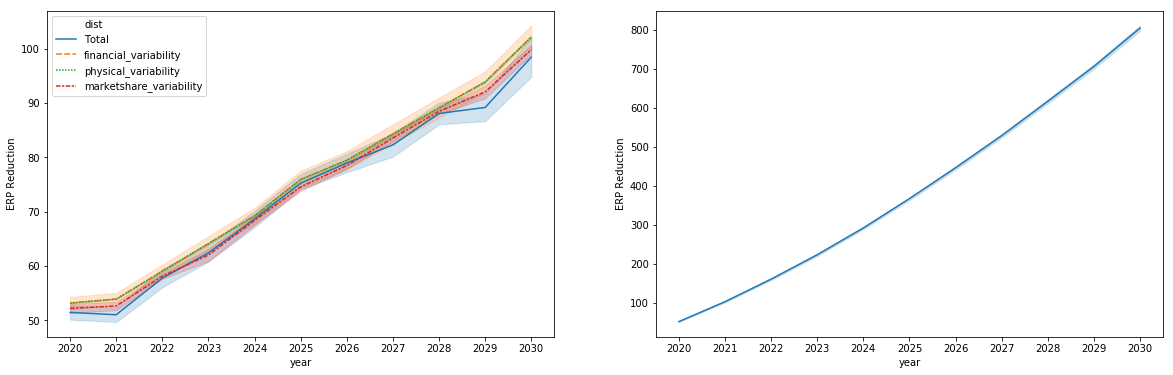

In [231]:
#The class is built on values fed in from Crane Database
example = Report(years, 
                 TAM_size, 
                 Target_Market_size_ref, 
                 Total_DIRECT_GHG_footprint_of_TAM_ref,
                 INDIRECT_GHG_intensity_of_Target_Market_ref,
                 Total_DIRECT_GHG_footprint_of_Target_Market_ref,
                 Elasticity_of_demand_for_Tarket_Market)

#We can then tune values when we call the function using user inputs
example.generate_report(Financial_FOM_mean = -.30,
                         Financial_FOM_std = .01,
                         Physical_FOM_mean = .50,
                         Physical_FOM_std = .01,
                         Market_Share_of_Solution_arr = Market_Share_of_Solution_arr,
                         Market_Share_of_Solution_std = .0005,
                         samples = 10000,
                         distribution = 'uniform',
                         plot = True)

0.5 0.5
min cum:  361.5051861202166 max cum: 369.1454505496403
0.5 0.75
min cum:  398.4554545309045 max cum: 406.7362560790889
0.5 1.0
min cum:  433.82951052987653 max cum: 441.90932935659634
0.5 1.25
min cum:  461.2731605873018 max cum: 469.61088185217915
0.5 1.5
min cum:  487.5647300304038 max cum: 495.82159462693255
0.75 0.5
min cum:  527.9093420462365 max cum: 537.207613169821
0.75 0.75
min cum:  567.158680901071 max cum: 576.5523663246545
0.75 1.0
min cum:  598.7394349450484 max cum: 610.169934822941
0.75 1.25
min cum:  631.9390988157922 max cum: 641.7606092186093
0.75 1.5
min cum:  657.100703417836 max cum: 667.347928539717
1.0 0.5
min cum:  720.2763419997208 max cum: 731.6838887375771
1.0 0.75
min cum:  765.2494812006453 max cum: 776.9760185177533
1.0 1.0
min cum:  803.0650335388962 max cum: 815.0777426162906
1.0 1.25
min cum:  835.1089868427173 max cum: 847.5859613112732
1.0 1.5
min cum:  863.6867574543006 max cum: 876.2237268408879
1.25 0.5
min cum:  936.9163755540334 max cum:

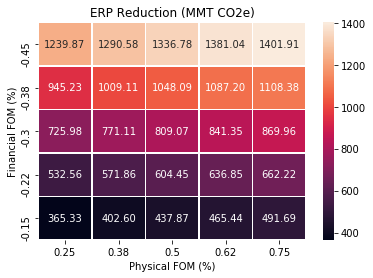

In [232]:
example.generate_comparables(
                         Financial_FOM_mean = -.30,
                         Financial_FOM_std = .01,
                         Physical_FOM_mean = .50,
                         Physical_FOM_std = .01,
                         Market_Share_of_Solution_arr = Market_Share_of_Solution_arr,
                         Market_Share_of_Solution_std = .0005,
                         samples = 10000,
                         distribution = 'uniform',
                         plot = False)

## What all the classes do

#### MarketShareHandler

In [82]:
class MarketShareHandler:
    def __init__(self, 
                 market_share,
                 years):
        """
        This class handles multiple different types of market share input
            1. If only input 1 number for msos but multiple for years
                then broadcast number to same size as years array
            2. If they're all the same value, do nothing
            3. Otherwise interpolate between start year and end year
            
        Input: what ever is put for market_share and years associated
        Output: an array of market_share values as long as the years array in numpy form
        """
        self.msos = market_share
        self.years = years
    def convert_to_series(self, method=None, include_raw=False):
        if (len(self.msos) == 1):
            tmp = np.ones(len(self.years))
            tmp = tmp * self.msos
            return tmp
        elif (len(np.unique(self.msos)) == 1):
            return self.msos
        else: #interpolate
            start_year = min(self.years)
            end_year = max(self.years)
            tmp = interpolate(self.years, self.msos, include_raw=include_raw, method=method)
            tmp = tmp.loc[start_year:end_year].apply(lambda x: min(x, 1.0))
            return np.array(tmp)
            

#### Pretty much a copy of the interpolate code from Cassie

In [60]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from typing import List


def line(x, a, b):
    return a * x + b

def poly_2(x, a, b, c):
    return a * x**2 + b * x + c

def poly_3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def logistic(x, a, b, c):
    return a / (1 + b * np.exp(c * x))

def exponential(x, a, b):
    return a * np.exp(b * x)

def interpolate(years: List, values: List, include_raw: bool=True, method: str=None, multiplier: float=1.0,
                shift_adjust: float=1.05981352321757) -> pd.DataFrame:
    """
    :param years: list of years for known values
    :param values: list of known raw values
    :param include_raw: if True, use raw values if available
    :param method: [linear, polynomial 2nd order, polynomial 3rd order, s-curve, exponential]
    default None; specify which curve-fitting method to use
    :param multiplier: default 1.0; multiplier to convert raw values to desired unit. If conversion is more complicated
    than a multiplier, perform interpolation first, then convert output
    :param shift_adjust: for s-curve - constant by which to adjust numerator
    :return:
    """
    # shift_adjust default value comes from Drawdown SolarPVUtility_RRS model. see Sheet Data Interpolator, cell BW21
    start_year = 2005
    end_year = 2060
    base_year = 2020
    curve_options = [line, poly_2, poly_3, logistic, exponential]
    curve_names = ['linear', 'polynomial 2nd order', 'polynomial 3rd order', 's-curve', 'exponential']
    all_years = np.asarray((range(start_year, end_year + 1)))

    years_shifted = np.asarray(years) - base_year
    values_converted = np.asarray(values) * multiplier

    if method in curve_names:
        method_idx = curve_names.index(method)
        func = curve_options[method_idx]
        if method == 's-curve':
            # linearize logistic function to constrain curve fit (and be consistent with Drawdown)
            # note that Drawdown similarly estimates coefficients for the exponential curve by linearizing data,
            # but I'm choosing to optimize directly with the exponential function because it is more "constrained"
            # than the logistic function and Python is capable of doing this curve fit
            a_fixed = max(values_converted) + shift_adjust
            log_values = np.log(a_fixed / np.asarray(values_converted) - 1)
            log_popt, pcov = curve_fit(line, years_shifted, log_values)
            popt = np.array([a_fixed, np.exp(log_popt[1]), log_popt[0]])
        else:
            popt, pcov = curve_fit(func, years_shifted, values_converted)
        func_r2 = pearsonr(values, func(years_shifted, *popt))[0] ** 2
        print("Coefficient of determination for {} fit: {}".format(method, func_r2))
        print("Parameters: {}".format(popt))
        y_interp = func(all_years - base_year, *popt)
    else:
        best_func = None
        best_func_params = None
        r2 = 0
        print("Coefficient of determination:")
        for i, func in enumerate(curve_options):
            if i == 3:
                a_fixed = max(values_converted) + shift_adjust
                log_values = np.log(a_fixed / np.asarray(values_converted) - 1)
                log_popt, pcov = curve_fit(line, years_shifted, log_values)
                popt = np.array([a_fixed, np.exp(log_popt[1]), log_popt[0]])
            else:
                popt, pcov = curve_fit(func, years_shifted, values_converted)
            func_r2 = pearsonr(values, func(years_shifted, *popt))[0] ** 2
            print('{}: {}'.format(curve_names[i], func_r2))

            if func_r2 > r2:
                r2 = func_r2
                best_func = func
                best_func_name = curve_names[i]
                best_func_params = popt
        print('Best fit is {} with parameters {}'.format(best_func_name, best_func_params))
        y_interp = best_func(all_years-base_year, *best_func_params)

    result = pd.Series(y_interp, index=all_years)

    #plt.plot(result.index, result, 'b-', years, values_converted, 'ko')
    #plt.xlabel('Year')
    #plt.show()

    if include_raw:
        for y_idx, y in enumerate(years):
            result.loc[result.index == y] = values_converted[y_idx]

    return result


#### Code that made the report and graph

In [230]:
class Report:
    def __init__(self, 
                 years, 
                 arr_TAM_size, 
                 arr_Target_Market_size_ref, 
                 arr_Total_DIRECT_GHG_footprint_of_TAM_ref,
                 INDIRECT_GHG_intensity_of_Target_Market_ref,
                 Total_DIRECT_GHG_footprint_of_Target_Market_ref,
                 Elasticity_of_demand_for_Tarket_Market):
        """
        The constructor holds all the data that gets fed in from the Crane Data base
        """
        
        #Dynamic researcher values, change over time
        self.arr_TAM_size = arr_TAM_size
        self.arr_Target_Market_size_ref = arr_Target_Market_size_ref
        self.arr_Total_DIRECT_GHG_footprint_of_TAM_ref = arr_Total_DIRECT_GHG_footprint_of_TAM_ref
        
        #assert inputs are of the same length
        assert (len(years) == len(arr_Target_Market_size_ref) &
                len(years) == len(arr_Total_DIRECT_GHG_footprint_of_TAM_ref) &
                len(years) == len(arr_TAM_size))
        
        self.years = years
        
        
        #Constant researcher values, consistent throughout time
        #numerator is MtCO2e; denominator varies by technology
        self.INDIRECT_GHG_intensity_of_Target_Market_ref = 0.091558
        # MtCO2e
        self.Total_DIRECT_GHG_footprint_of_Target_Market_ref = 0.0  
        
        self.Elasticity_of_demand_for_Tarket_Market = -.75#unitless
        
        """
        output variables
        """
        self._erp_std = ""
        self._erp_mean = ""
        
    def create_datapoint(self,
                         TAM_size, 
                         Target_Market_size_ref, 
                         Total_DIRECT_GHG_footprint_of_TAM_ref, 
                         Market_Share_of_Solution,
                         Market_Share_of_Solution_std,
                         distribution):
            """
            This function takes the inputs and calculates # of samples of each year,
            It essentially is an implementation of the excel sheet, but the input values are 
            determined by the user. 
            
            Inputs: user input values
            Outputs: mean, standard deviation, figures_of_merit
            """
            #Setting Constants
            samples = self.samples
            igiotmf = self.INDIRECT_GHG_intensity_of_Target_Market_ref
            tdgfotmf = self.Total_DIRECT_GHG_footprint_of_Target_Market_ref
            Elasticity_of_demand_for_Tarket_Market = self.Elasticity_of_demand_for_Tarket_Market#unitless
            
            Financial_FOM_mean = self.Financial_FOM_mean
            Financial_FOM_std = self.Financial_FOM_std
            Physical_FOM_mean = self.Physical_FOM_mean
            Physical_FOM_std = self.Physical_FOM_std
            
            ###Everything below this are the calculations taken from the excel sheet
            #Ref Scenario Calculations from Excel Sheet
            Remaining_Market_size_ref = TAM_size - Target_Market_size_ref #
            DIRECT_GHG_Intensity_of_TAM_ref = tdgfotmf/TAM_size# numerator is MtCO2e; denominator varies by technology
            DIRECT_GHG_Intensity_of_Remaining_Market = (Total_DIRECT_GHG_footprint_of_TAM_ref - tdgfotmf)/Remaining_Market_size_ref# numerator is MtCO2e; denominator varies by technology
            DIRECT_GHG_intensity_of_Target_Market_ref = tdgfotmf/Target_Market_size_ref# numerator is MtCO2e; denominator varies by technology

            Total_INDIRECT_GHG_footprint_of_Target_Market_ref = Target_Market_size_ref * igiotmf# MtCO2e
            Total_DIRECT_GHG_footprint_of_Remaining_Market_ref = Remaining_Market_size_ref * DIRECT_GHG_Intensity_of_Remaining_Market# MtCO2e
            Total_GHG_footprint_of_TAM_ref = Total_INDIRECT_GHG_footprint_of_Target_Market_ref + tdgfotmf + Total_DIRECT_GHG_footprint_of_Remaining_Market_ref#MtCO2e

            erp_tmp = []
            
            """
            I iterate through the next batch of calculations n (samples)
                number of times based on specificed distribution.
                
            I generate values for the total erp output and also the erp output
                when I only take the volatility of a single variable for each
                physical, finacial, and market share. 
                
            While you can select the different distribution types for total output,
                the ones with fixed variables are in _uni_ (uniform) distribution.
                
            """
            for i in range(samples):

               # User input values in solution description
                # for generating random values
                if distribution == 'uniform':
                    Relative_Financial_FOM = uniform(Financial_FOM_mean - Financial_FOM_std, Financial_FOM_mean + Financial_FOM_std) #%change
                    Relative_Physical_FOM = uniform(Physical_FOM_mean - Physical_FOM_std, Physical_FOM_mean + Physical_FOM_std) #%change
                    Market_Share_of_Solution = uniform(Market_Share_of_Solution - Market_Share_of_Solution_std, Market_Share_of_Solution + Market_Share_of_Solution_std)
                elif distribution == 'normal':
                    Relative_Financial_FOM = gauss(Financial_FOM_mean, Financial_FOM_std) #%change
                    Relative_Physical_FOM = gauss(Physical_FOM_mean, Physical_FOM_std) #%change
                    Market_Share_of_Solution = gauss(Market_Share_of_Solution, Market_Share_of_Solution_std)
                    
                # for generating values where only a single FOM is allowed to deviate
                elif distribution == 'physical_uni':
                    Relative_Financial_FOM = Financial_FOM_mean #%change
                    Relative_Physical_FOM = uniform(Physical_FOM_mean - Physical_FOM_std, Physical_FOM_mean + Physical_FOM_std) #%change
                elif distribution == 'financial_uni':
                    Relative_Financial_FOM = uniform(Financial_FOM_mean - Financial_FOM_std, Financial_FOM_mean + Financial_FOM_std) #%change
                    Relative_Physical_FOM = Physical_FOM_mean
                elif distribution == 'marketshare_uni':
                    Relative_Financial_FOM = Financial_FOM_mean
                    Relative_Physical_FOM = Physical_FOM_mean
                    Market_Share_of_Solution = uniform(Market_Share_of_Solution - Market_Share_of_Solution_std, Market_Share_of_Solution + Market_Share_of_Solution_std)
                
                # make sure its a real distribution
                else:
                    print("not a real distribution")
                    break
                
                
                # max out at 100% of market share
                """
                cap at 100% marketshare
                """
                Market_Share_of_Solution = min(Market_Share_of_Solution, 1.0)

                #Solution Deployed Calculations
                INDIRECT_GHG_intensity_of_Solution = igiotmf/(1 + Relative_Physical_FOM)
                DIRECT_GHG_intensity_of_Solution  = DIRECT_GHG_intensity_of_Target_Market_ref/(1 + Relative_Physical_FOM) #numerator is MtCO2e; denominator varies by technology
                Target_Market_size_sol = Target_Market_size_ref * (2/(1 - (Elasticity_of_demand_for_Tarket_Market * Market_Share_of_Solution*Relative_Financial_FOM /(2 + Market_Share_of_Solution*Relative_Financial_FOM))) - 1)# in Solution Scenario(s)
                Remaining_Market_size_sol = TAM_size - Target_Market_size_sol# in Solution Scenario(s)
                DIRECT_GHG_intensity_of_Target_Market_sol = DIRECT_GHG_intensity_of_Target_Market_ref*(1-Market_Share_of_Solution) + DIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution# in Solution Scenario(s)
                Total_DIRECT_GHG_footprint_of_TAM_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol + Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)
                INDIRECT_GHG_intensity_of_Target_Marke_sol = igiotmf * (1 - Market_Share_of_Solution) + INDIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution#  in Solution Scenario(s)
                Total_INDIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * INDIRECT_GHG_intensity_of_Target_Marke_sol# in Solution Scenario(s)
                Total_DIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol# in Solution Scenario(s)
                Total_DIRECT_GHG_footprint_of_Remaining_Market_sol = Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)

                Total_GHG_footprint_of_TAM_sol = Total_INDIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Remaining_Market_sol# in Solution Scenario(s)
                
                #The output we care about
                Emissions_Reduction_Potentional_annually = Total_GHG_footprint_of_TAM_ref  - Total_GHG_footprint_of_TAM_sol
                #append each data point for the given year
                erp_tmp.append(Emissions_Reduction_Potentional_annually)
    
            erp_data = np.array(erp_tmp)
            # return mean and stdv of the returned datapoints
            return np.mean(erp_data), np.std(erp_data)
        
    def appendMeanAndDeviations(self, annual_df, mean, std, year, distribution):
        """
        This function appends the mean and +-1std bounds to a dataframe
        Distribution is the type of function that is used to generate the data
        The mean and bounds are appended to the same column and same year, this format is what seaborn prefers
        """
        annual_df = annual_df.append({"ERP Reduction": mean - std, "year": year, "dist": distribution}, ignore_index=True )
        annual_df = annual_df.append({"ERP Reduction": mean, "year": year, "dist": distribution}, ignore_index=True )
        annual_df = annual_df.append({"ERP Reduction": mean + std, "year": year, "dist": distribution}, ignore_index=True )
        return annual_df
    
    def batch_create_datapoint(self,
                        TAM_size, 
                        Target_Market_size_ref, 
                        Total_DIRECT_GHG_footprint_of_TAM_ref, 
                        Market_Share_of_Solution,
                        Market_Share_of_Solution_std,
                        distribution):
        """this function creates all datapoints for the entire year"""
        
        # generate data point for the year
        mean, std= self.create_datapoint(
                     TAM_size = TAM_size, 
                     Target_Market_size_ref = Target_Market_size_ref, 
                     Total_DIRECT_GHG_footprint_of_TAM_ref = Total_DIRECT_GHG_footprint_of_TAM_ref, 
                     Market_Share_of_Solution = Market_Share_of_Solution,
                     Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                     distribution = distribution)

        # generate data with financial fom variable while others fixed. Dist is uniform (uni)
        fin_mean, fin_std = self.create_datapoint(
                     TAM_size = TAM_size, 
                     Target_Market_size_ref = Target_Market_size_ref, 
                     Total_DIRECT_GHG_footprint_of_TAM_ref = Total_DIRECT_GHG_footprint_of_TAM_ref, 
                     Market_Share_of_Solution = Market_Share_of_Solution,
                     Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                     distribution = "financial_uni")

        # generate data with phys fom variable
        phys_mean, phys_std= self.create_datapoint(
                     TAM_size = TAM_size, 
                     Target_Market_size_ref = Target_Market_size_ref, 
                     Total_DIRECT_GHG_footprint_of_TAM_ref = Total_DIRECT_GHG_footprint_of_TAM_ref, 
                     Market_Share_of_Solution = Market_Share_of_Solution,
                     Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                     distribution = "physical_uni")

        # generate data with marketshare information
        msos_mean, msos_std= self.create_datapoint(
                     TAM_size = TAM_size, 
                     Target_Market_size_ref = Target_Market_size_ref, 
                     Total_DIRECT_GHG_footprint_of_TAM_ref = Total_DIRECT_GHG_footprint_of_TAM_ref, 
                     Market_Share_of_Solution = Market_Share_of_Solution,
                     Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                     distribution = "marketshare_uni")
        
        return mean, std, fin_mean, fin_std, phys_mean, phys_std, msos_mean, msos_std
            
    def generate_report(self, 
                        Financial_FOM_mean, 
                        Financial_FOM_std, 
                        Physical_FOM_mean,
                        Physical_FOM_std,
                        Market_Share_of_Solution_arr,
                        Market_Share_of_Solution_std,
                        samples = 10000,
                        distribution = 'normal',
                        plot = True):
        
        """
        This function iterates through the years and calls create datapoint on each. 
            headers of annual_df : [{ERP Reduction, year, dist}]
                ERP Reduction : Mean of 
                Year is the input year
                dist is used to distinguish the type of distribution used
        
        It then plots the annual erp reduction and the cummulative. 
            The cummulative stdev is calculated using root-mean-square
        """
        
        #initializing constants
        self.samples = samples
        self.distribution = distribution
        self.Financial_FOM_mean = Financial_FOM_mean
        self.Financial_FOM_std = Financial_FOM_std
        self.Physical_FOM_mean = Physical_FOM_mean
        self.Physical_FOM_std = Physical_FOM_std
        
        
        #initializing some empty arrays
        annual_df = pd.DataFrame()
        cum_df = pd.DataFrame()
        arr_std = np.array([])
        arr_mean = np.array([])
        
        #loading these arrays from Crane database that were constructed in the object
        arr_TAM_size= self.arr_TAM_size 
        arr_Target_Market_size_ref = self.arr_Target_Market_size_ref 
        arr_Total_DIRECT_GHG_footprint_of_TAM_ref = self.arr_Total_DIRECT_GHG_footprint_of_TAM_ref  
        
        #iterate through each year of each database
        for input_index, year in enumerate(self.years):
                        
            mean, std, fixed_phys_mean, fixed_phys_std, fixed_fin_mean, fixed_fin_std, msos_mean, msos_std = self.batch_create_datapoint(
                         TAM_size = arr_TAM_size[input_index], 
                         Target_Market_size_ref = arr_Target_Market_size_ref[input_index], 
                         Total_DIRECT_GHG_footprint_of_TAM_ref = arr_Total_DIRECT_GHG_footprint_of_TAM_ref[input_index], 
                         Market_Share_of_Solution = Market_Share_of_Solution_arr[input_index],
                         Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                         distribution = distribution)    
            
            ### for graphing annual erp
            #append values to annual erp data frame 
            annual_df = self.appendMeanAndDeviations(annual_df, mean, std, year, "Total")
            annual_df = self.appendMeanAndDeviations(annual_df, fixed_phys_mean, fixed_phys_std, year, "financial_variability")
            annual_df = self.appendMeanAndDeviations(annual_df, fixed_fin_mean, fixed_fin_std, year, "physical_variability")
            annual_df = self.appendMeanAndDeviations(annual_df, msos_mean, msos_std, year, "marketshare_variability")
            
            ### everything below this is for calculating the cummulative erp
            #need to calculate root mean square of all tolerances
            arr_std = np.append(arr_std, std)
            cum_std = np.sqrt(np.sum(np.square(arr_std)))
            arr_mean = np.append(arr_mean, mean)
            cum_mean = np.sum(arr_mean)
            
            #append values to cummulative erp
            cum_df = self.appendMeanAndDeviations(cum_df, cum_mean, cum_std, year, "cummulative")

        last_mean = cum_mean
        last_std = cum_std
        
        print ("min cum: ", last_mean-last_std, "max cum:", last_mean+last_std)
        
        if plot:
            #annual and cummulative plot
            fig, ax =plt.subplots(1,2, figsize=(20,6))
            sns.lineplot(x="year", y="ERP Reduction", data=annual_df, ax=ax[0], hue="dist", style="dist") #annual
            sns.lineplot(x="year", y="ERP Reduction", data=cum_df, ax=ax[1]) #cummulative

            #points_df = pd.DataFrame([3.5, 0.5, 1.75, 4.25], index=['a', 'b', 'c', 'd']).transpose()
            #sns.pointplot(data=points_df, join=False, color='red', ax=ax, zorder=1)

            plt.setp(ax, xticks=self.years)
            fig.show()
        
        #this just outputs the cummulative results of the report generation in case the numbers are wanted
        self._erp_mean = last_mean
        self._erp_std = last_std
        
    def generate_comparables(self,
                         Financial_FOM_mean = -.30,
                         Financial_FOM_std = .01,
                         Physical_FOM_mean = .50,
                         Physical_FOM_std = .01,
                         Market_Share_of_Solution_arr = Market_Share_of_Solution_arr,
                         Market_Share_of_Solution_std = .0005,
                         samples = 10000,
                         distribution = 'uniform',
                         plot = False):
        # range of values to iterate over
        fin_val = [.5, .75, 1.0, 1.25, 1.5]
        phys_val = [.5, .75, 1.0, 1.25, 1.5]
        result_df = []
        
        for fin_multiplier in fin_val:
            for phys_multiplier in phys_val:
                print(fin_multiplier, phys_multiplier)
                self.generate_report(Financial_FOM_mean = Financial_FOM_mean * fin_multiplier,
                                 Financial_FOM_std = Financial_FOM_std,
                                 Physical_FOM_mean = Physical_FOM_mean * phys_multiplier,
                                 Physical_FOM_std = Physical_FOM_std,
                                 Market_Share_of_Solution_arr = Market_Share_of_Solution_arr,
                                 Market_Share_of_Solution_std = Market_Share_of_Solution_std,
                                 samples = samples,
                                 distribution = distribution,
                                 plot = False)
                
                result_df.append([round(Financial_FOM_mean * fin_multiplier, 2), round(Physical_FOM_mean* phys_multiplier, 2), self._erp_mean])
        
        result_df = pd.DataFrame(result_df)
        #print(result_df)
        result_df.columns = ["Financial FOM (%)", "Physical FOM (%)", "ERP Reduction"]
        result_df = result_df.pivot(index='Financial FOM (%)', columns='Physical FOM (%)', values='ERP Reduction')
        ax = sns.heatmap(result_df,
                   annot = True,
                   fmt='.2f',
                   linewidths=.5)
        ax.set_title('ERP Reduction (MMT CO2e)')


## Presenting data properly
## How best to show users and narrative behind what users need to believe
## why numbers
## visual mockup would be nice, what should they see.